# Modelo de Clasificación - v3

"{'algoritmo': LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, min_child_samples=50,
               n_estimators=300, num_leaves=15, subsample=0.8), 'algoritmo__colsample_bytree': 0.8, 'algoritmo__learning_rate': 0.01, 'algoritmo__max_depth': -1, 'algoritmo__min_child_samples': 50, 'algoritmo__n_estimators': 300, 'algoritmo__num_leaves': 15, 'algoritmo__reg_alpha': 0.0, 'algoritmo__reg_lambda': 0.0, 'algoritmo__subsample': 0.8}"



## IMPORTACIÓN DE PAQUETES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from lightgbm import LGBMClassifier

#metricas de evaluación
#Métricas de evaluación
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

#Crear Pipeline
from sklearn.pipeline import make_pipeline

import cloudpickle

## IMPORTAR LOS DATOS

### CARGAR LOS DATOS

In [2]:
df = pd.read_pickle('../../02_Datos/03_Trabajo/tablon_analitico.pickle')
df.head()

,wifi1,wifi2,wifi3,wifi4,wifi5,wifi6,wifi7,room
0,-64,-56,-61,-66,-71,-82,-81,1
1,-63,-60,-60,-67,-76,-85,-84,1
2,-61,-60,-68,-62,-77,-90,-80,1
3,-63,-65,-60,-63,-77,-81,-87,1
4,-64,-55,-63,-66,-76,-88,-83,1


### SEPARAR PREDICTORAS Y TARGET

In [3]:
x = df.drop(columns= 'room').copy()
y = df.room.copy()

In [4]:
x.head()

,wifi1,wifi2,wifi3,wifi4,wifi5,wifi6,wifi7
0,-64,-56,-61,-66,-71,-82,-81
1,-63,-60,-60,-67,-76,-85,-84
2,-61,-60,-68,-62,-77,-90,-80
3,-63,-65,-60,-63,-77,-81,-87
4,-64,-55,-63,-66,-76,-88,-83


In [5]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: room, dtype: int64

## MODELIZAR

### CARGAMOS EL MEJOR MODELO CON EL ALGORITMO, PARÁMETROS Y VALORES

In [8]:
modelo = pd.read_pickle('../../04_Modelos/Best_Estimator/LGBMClassifier_v03.pickle')

### EXAMINAR MODELO

In [9]:
modelo.best_estimator_

Pipeline(steps=[('algoritmo',
                 LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01,
                                min_child_samples=50, n_estimators=300,
                                num_leaves=15, subsample=0.8))])

In [10]:
modelo.best_params_

{'algoritmo': LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, min_child_samples=50,
                n_estimators=300, num_leaves=15, subsample=0.8),
 'algoritmo__colsample_bytree': 0.8,
 'algoritmo__learning_rate': 0.01,
 'algoritmo__max_depth': -1,
 'algoritmo__min_child_samples': 50,
 'algoritmo__n_estimators': 300,
 'algoritmo__num_leaves': 15,
 'algoritmo__reg_alpha': 0.0,
 'algoritmo__reg_lambda': 0.0,
 'algoritmo__subsample': 0.8}

### PREDECIR SOBRE LA VALIDACIÓN

In [11]:
pred = modelo.best_estimator_.predict(x)

### EVALUAR SOBRE LA VALIDACIÓN

In [12]:
t_accuracy = accuracy_score(y, pred)
t_report = classification_report(y, pred)

print(f"Accuracy: {t_accuracy}\n")
print(f"Classification Report:\n{t_report}")

Accuracy: 0.9871428571428571

Classification Report:
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       352
           2       0.99      0.97      0.98       335
           3       0.97      0.99      0.98       350
           4       1.00      1.00      1.00       363

    accuracy                           0.99      1400
   macro avg       0.99      0.99      0.99      1400
weighted avg       0.99      0.99      0.99      1400



#### Gráfico entre la diferencia entre la validación y el original

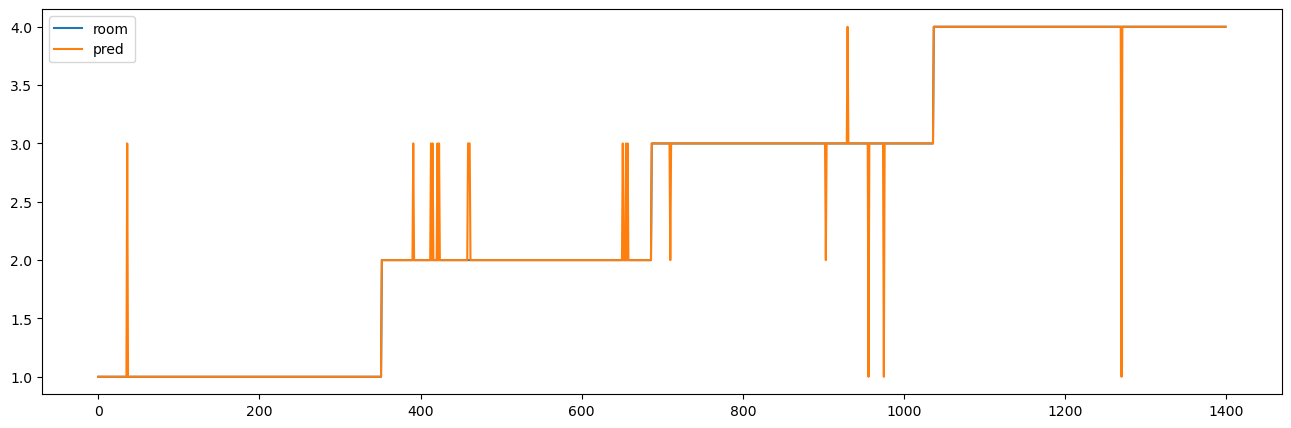

In [13]:
test_y = y.reset_index().copy()
test_pred = pd.Series(pred).to_frame()
df_pred = pd.concat([test_y,test_pred], axis= 1).sort_values(by='room').reset_index()
df_pred.rename(columns = {0:'pred'}, inplace = True)
df_pred = df_pred.drop(columns= ['level_0'])
df_pred[['room','pred']].plot(figsize=(16,5));

## REPORTING DEL MODELO

Matrix de Confusión MultiClass

Text(0.5, 1.0, 'Confusion Matrix')

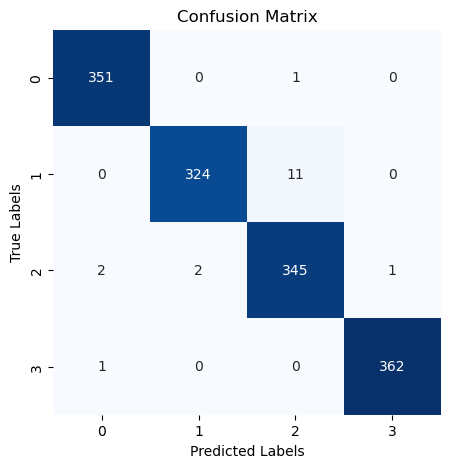

In [14]:
# Calcular la matriz de confusión
cm = confusion_matrix(y, pred)


# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)

# Configurar etiquetas y título del gráfico
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")


ROC CHART MULTICLASS

c:\Users\ialca\anaconda3\envs\proyecto1\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


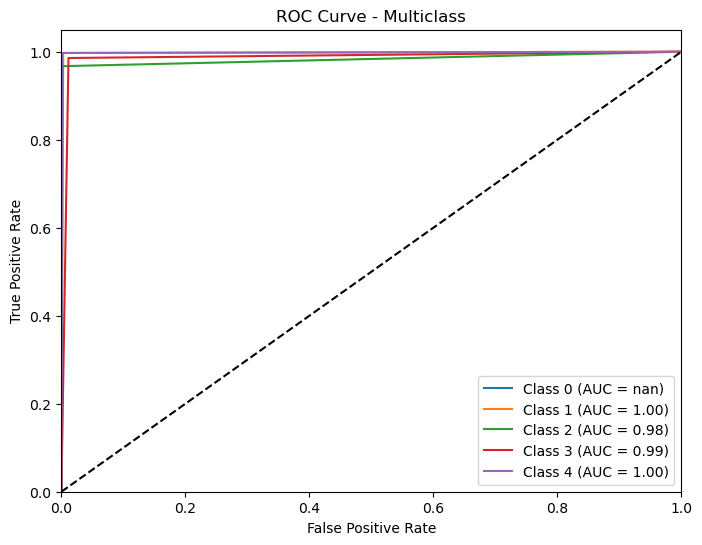

In [15]:
# Binarizar las etiquetas verdaderas y las predicciones para cada clase
n_classes = len(np.unique(y))+1
binarized_val_y = label_binarize(y, classes=np.arange(n_classes))
binarized_pred = label_binarize(pred, classes=np.arange(n_classes))

# Calcular la curva ROC y el área bajo la curva (AUC) para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_val_y[:, i], binarized_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotear el gráfico ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

# Configurar etiquetas y título del gráfico
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass')
plt.legend(loc="lower right");

## CREAR PIPELINE DE ENTRENAMIENTO Y EJECUCIÓN

### INSTANCIAR EL MODELO

In [16]:
modelo = LGBMClassifier(colsample_bytree= 0.8,
                        learning_rate= 0.01,
                        max_depth=-1,
                        min_child_samples= 50,
                        n_estimators= 300,
                        num_leaves=15,
                        reg_alpha=0.0,
                        reg_lambda= 0.0,
                        subsample= 0.8)

### CREAR EL PIPE FINAL DE ENTRENAMIENTO

In [17]:
pipe_entrenamiento = make_pipeline(modelo)

### GUARDAR EL PIPE FINAL DE ENTRENAMIENTO 


In [18]:
nombre_pipe_entrenamiento = 'pipe_entrenamiento_v3.pickle'
ruta_pipe_entrenamiento = '../../04_Modelos/' + nombre_pipe_entrenamiento

with open (ruta_pipe_entrenamiento, mode= 'wb') as file:
    cloudpickle.dump(pipe_entrenamiento, file)

### ENTRENAR EL PIPE FINAL DE EJECUCIÓN

In [19]:
pipe_ejecucion = pipe_entrenamiento.fit(x,y)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 7
[LightGBM] [Info] Start training from score -1.380596
[LightGBM] [Info] Start training from score -1.430097
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.349825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


### GUARDAR EL PIPE FINAL DE EJECUCIÓN

In [20]:
nombre_pipe_ejecucion = 'pipe_ejecucion_v3.pickle'
ruta_pipe_ejecucion = '../../04_Modelos/' + nombre_pipe_ejecucion

with open (ruta_pipe_ejecucion, mode= 'wb') as file:
    cloudpickle.dump(pipe_ejecucion, file)